In [1]:
import math
%load_ext autoreload
%autoreload 2
exec(open('init_notebook.py').read())
from matplotlib import pyplot as plt
from highD.HighD import HighD
from highD.Filter import Filter
from highD.Plot import Plot
from highD.Visualizer import GIF
from highD.helper import *

current working dirC:\Users\abjawad\Documents\GitHub\cogMod-driver-behavior-model\highd_tools


In [2]:

class IntelligentDriverModel():
    def __init__(self, desired_velocity, safe_time_headway, max_acceleration, comfort_deceleration, acceleration_exponent, minimum_distance, vehicle_length, far_distance):
        self.desired_velocity = desired_velocity
        self.safe_time_headway = safe_time_headway
        self.max_acceleration = max_acceleration
        self.comfort_deceleration = comfort_deceleration
        self.acceleration_exponent = acceleration_exponent
        self.minimum_distance = minimum_distance
        self.vehicle_length = vehicle_length
        self.far_distance = far_distance
        
        self.acceleration = []
        self.deceleration = []
        self.gap = []
        self.acc_subtract = []

    def update(self, ego_velocity, preceding_vehicle_velocity, distance_delta):
        self.ego_velocity = ego_velocity
        self.preceding_vehicle_velocity = preceding_vehicle_velocity
        self.distance_delta = distance_delta
        self.next_acceleration = self.calc_acceleration()

    def calc_acceleration(self):
        acceleration = math.pow((self.ego_velocity / self.desired_velocity), self.acceleration_exponent)
        deceleration = math.pow(self.calc_desired_gap() / min(self.far_distance, self.distance_delta), 2)
        self.acceleration.append(acceleration)
        self.deceleration.append(deceleration)
        self.gap.append(self.calc_desired_gap())
        self.acc_subtract.append(1 - acceleration - deceleration)
        return float(self.max_acceleration * (1 - acceleration - deceleration))

    def calc_desired_gap(self):
        del_v = (self.ego_velocity - self.preceding_vehicle_velocity)
        ab = self.max_acceleration * self.comfort_deceleration
        c = ((self.safe_time_headway * self.ego_velocity) + ((self.ego_velocity * del_v) / (2 * math.sqrt(ab))))
        return float(self.minimum_distance + max(0, c))


In [3]:
ids = ["01", "02"]
highD = HighD(ids, DATA_DIRECTORY)

dataset_id = 1
_, tMeta, tracks = highD.get_dataframe_tuple(dataset_id)
df = highD.get_combined_dataframe(dataset_id)
image = highD.get_image(dataset_id)
print(df.columns)

Loaded data and image for dataset 01.
Loaded data and image for dataset 02.
Index(['dataset_id', 'locationId', 'frame', 'id', 'class', 'drivingDirection',
       'laneId', 'x', 'y', 'width', 'height', 'xVelocity', 'yVelocity',
       'xAcceleration', 'yAcceleration', 'frontSightDistance',
       'backSightDistance', 'dhw', 'thw', 'ttc', 'precedingXVelocity',
       'precedingId', 'followingId', 'leftPrecedingId', 'leftAlongsideId',
       'leftFollowingId', 'rightPrecedingId', 'rightAlongsideId',
       'rightFollowingId'],
      dtype='object')


In [4]:
follow_meta = Filter.filter_vehicle_follow_scenario(df, 
                                      ego_type='Car', 
                                      preceding_type='Car',
                                      minDuration=5, 
                                      minStartDistance=50,
                                      maxStartDistance=100, 
                                      removeStrictDistanceInc=True)

print(follow_meta.shape)
follow_meta.head()

Filtering vehicle follow scenario Car Car 5 50 100
total actors 1047, filtered actors 730, ratio 0.6972301814708691
total actors 1047, filtered actors 730, ratio 0.6972301814708691
total scenario 10, filtered scenario 5, ratio 0.5
(5, 8)


,ego_id,preceding_id,start_frame,end_frame,duration,start_distance,max_distance,min_distance
2,50,47,994,1211,8.68,61.680066,61.850137,50.781906
3,386,380,7878,8100,8.88,99.580025,99.580025,51.590035
5,680,678,14277,14510,9.32,68.200188,81.370325,68.200188
6,976,974,21037,21263,9.04,53.295855,56.650961,53.295855
7,1041,1037,22357,22539,7.28,97.970590,101.894064,97.970590


In [5]:
import numpy as np

scenario_id = 0
print('scenario id ', scenario_id)
scenario_follow_meta = follow_meta.iloc[scenario_id]
ego_id = int(scenario_follow_meta['ego_id'])
preceding_id = int(scenario_follow_meta['preceding_id'])
start_frame = int(scenario_follow_meta['start_frame'])
end_frame = int(scenario_follow_meta['end_frame'])
print(ego_id, preceding_id, start_frame, end_frame)

scenario id  0
50 47 994 1211


In [6]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

# Assume df is your DataFrame

# get data for ego and preceding vehicle
ego_df = df[(df['id'] == ego_id) & df['frame'].between(start_frame, end_frame)]
prec_df = df[(df['id'] == preceding_id) & df['frame'].between(start_frame, end_frame)]

# Initialize IDM with desired parameters
desired_velocity = ego_df['xVelocity'].max() + 10  # Desired speed is 10 m/s higher
safe_time_headway = 0.5
max_acceleration = ego_df[ego_df['xAcceleration'] > 0]['xAcceleration'].max()
comfort_deceleration = abs(ego_df[ego_df['xAcceleration'] < 0]['xAcceleration'].max())
acceleration_exponent = 4.0
minimum_distance = 1.0
vehicle_length = prec_df.iloc[0]['width'] # assuming the width is the length of the vehicle
far_distance = 100.0

T = 0.04


frame  994  delta  61.68000000000001  velocity diff  0.972135613610412
frame  995  delta  61.63911457545559  velocity diff  1.210928524183629
frame  996  delta  61.58867743448824  velocity diff  1.436365634733356
frame  997  delta  61.5288228090989  velocity diff  1.6584358261248084
frame  998  delta  61.45968537605391  velocity diff  1.8871299597134836
frame  999  delta  61.38140017766537  velocity diff  2.1024408759300783
frame  1000  delta  61.30410254262817  velocity diff  2.314363421858097
frame  1001  delta  61.20792800575384  velocity diff  2.5328943425423986
frame  1002  delta  61.11301223205215  velocity diff  2.7380324007828776
frame  1003  delta  61.00949093602084  velocity diff  2.9397782600319857
frame  1004  delta  60.87749980561955  velocity diff  3.1481344299449745
frame  1005  delta  60.74717442842176  velocity diff  3.3431054110571736
frame  1006  delta  60.61865021197947  velocity diff  3.544697565849468
frame  1007  delta  60.4620623093455  velocity diff  3.73291898

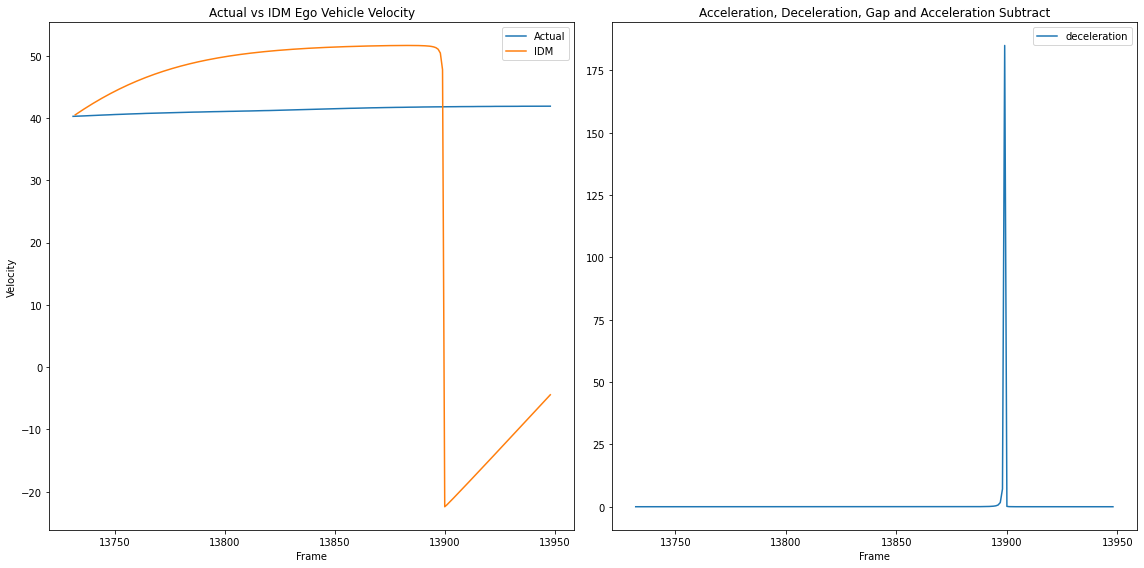

In [14]:
# Create a test scenario
idm = IntelligentDriverModel(desired_velocity, safe_time_headway, max_acceleration, comfort_deceleration, acceleration_exponent, minimum_distance, vehicle_length, far_distance)

ego_velocity_idm = [ego_df['xVelocity'].iloc[0]]
ego_x = ego_df.iloc[0]['x']
distances_data = [0]  # distance list for data
for _, prec in prec_df.iterrows():
    
    prec_velocity = prec['xVelocity']
    distance_delta = abs(ego_x - prec['x'])
    distances_data.append(distance_delta)
    last_ego_velocity = ego_velocity_idm[-1] if ego_velocity_idm else desired_velocity
    idm.update(last_ego_velocity, prec_velocity, distance_delta)
    new_velocity = last_ego_velocity + idm.next_acceleration  # Calculate next velocity
    ego_x = ego_x + new_velocity * T  # All movement is in x direction
    ego_velocity_idm.append(new_velocity)
    print('frame ', prec['frame'], ' delta ', distance_delta, ' velocity diff ', new_velocity - prec_velocity)

# Discard the last value to match the length with ego_df
ego_velocity_idm = ego_velocity_idm[:-1]
distances_data = distances_data[:-1]


plt.figure(figsize=(16, 8))  # Create a new figure and specify the size (optional)

# Plot velocity
plt.subplot(1, 2, 1)
plt.plot(ego_df.index, ego_df['xVelocity'], label='Actual')
plt.plot(ego_df.index[1:], ego_velocity_idm[1:], label='IDM')
plt.legend(loc='upper right')
plt.xlabel('Frame')
plt.ylabel('Velocity')
plt.title('Actual vs IDM Ego Vehicle Velocity')

# Plot acceleration, deceleration, gap and acceleration_subtract
plt.subplot(1, 2, 2)
# plt.plot(ego_df.index, idm.acceleration, label='acceleration')
plt.plot(ego_df.index[1:], idm.deceleration[1:], label='deceleration')
# plt.plot(ego_df.index[1:], idm.gap[1:], label='gap')
# plt.plot(ego_df.index[1:], idm.acc_subtract[1:], label='acceleration_subtract')
plt.legend(loc='upper right')
plt.xlabel('Frame')
plt.title('Acceleration, Deceleration, Gap and Acceleration Subtract')

plt.tight_layout()  # Ensure adequate spacing between plots
plt.show()
